In [12]:
from STalign import STalign
import anndata as ad
import numpy as np
import matplotlib.pyplot as plt
import nrrd
import torch
import skimage
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import pandas as pd
import pickle

In [3]:
adata = ad.read_h5ad("spatial_8327576.h5ad")

In [18]:
adata_well11 = adata[adata.obs["label"] == "well11"]

In [5]:
coordinates = pd.DataFrame(adata.obsm["spatial"][adata.obs["label"] == "well11"], columns=["x", "y"])

In [23]:
cell_index = adata_well11.obs_names.tolist()
with open("alignment_cell_index.pkl", "wb") as file:
    pickle.dump(cell_index, file)

In [6]:
#scale coordinates to
#the y size of a mid coronal section in allen reference atlas is 7200 um
#this corresponds to the x direction of the input
scale_factor = 7200 / (max(coordinates["x"]) - min(coordinates["x"]))
scale_factor

0.2085674423182659

In [7]:
coordinates["x"] = coordinates["x"] * 0.2
coordinates["y"] = coordinates["y"] * 0.2

In [8]:
coordinates

,x,y
0,2166.854545,297.690909
1,2427.881356,172.957627
2,2369.626415,245.135849
3,2218.196078,268.507843
4,2303.581132,270.347170
...,...,...
43336,6948.392727,5124.340909
43337,6876.158824,4937.314706
43338,6821.213636,5009.956061
43339,6929.640000,4896.938824


In [273]:
url = 'http://api.brain-map.org/api/v2/data/query.csv?criteria=model::Structure,rma::criteria,[ontology_id$eq1],rma::options[order$eq%27structures.graph_order%27][num_rows$eqall]'
ontology_name,namesdict = STalign.download_aba_ontology(url, 'allen_ontology.csv') #url for adult mouse

<Response [200]>


In [182]:
imageurl = 'http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/ara_nissl/ara_nissl_50.nrrd'
labelurl = 'http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/annotation_50.nrrd'
imagefile, labelfile = STalign.download_aba_image_labels(imageurl, labelurl, 'aba_nissl.nrrd', 'aba_annotation.nrrd')

In [430]:
dx=15
blur = 1
#Rasterize Image
X_,Y_,W = STalign.rasterize(coordinates["x"],coordinates["y"],dx=dx, blur = blur,draw=False)

Text(0.5, 1.0, 'Rasterized')

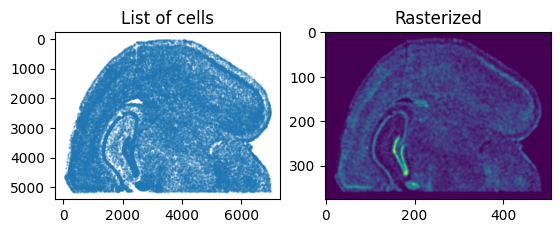

In [431]:
#Plot unrasterized/rasterized images
fig,ax = plt.subplots(1,2)
ax[0].scatter(coordinates["x"],coordinates["y"],s=0.5,alpha=0.25)
ax[0].invert_yaxis()
ax[0].set_title('List of cells')
ax[0].set_aspect('equal')

W = W[0]
extent = (X_[0],X_[-1],Y_[0],Y_[-1])
ax[1].imshow(W,  origin='lower')
ax[1].invert_yaxis()
ax[1].set_title('Rasterized')

# save figure
#fig.canvas.draw()
#fig.savefig(outname[:-4]+'_image.png')

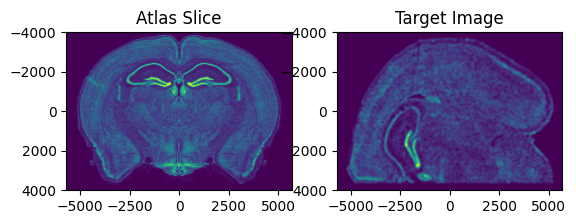

In [432]:
#find slice
#peruse through images in atlas
# Loading the atlas
slice = 140

vol,hdr = nrrd.read(imagefile)
A = vol
vol,hdr = nrrd.read(labelfile)
L = vol

dxA = np.diag(hdr['space directions'])
nxA = A.shape
xA = [np.arange(n)*d - (n-1)*d/2.0 for n,d in zip(nxA,dxA)]
XA = np.meshgrid(*xA,indexing='ij')

fig,ax = plt.subplots(1,2)
extentA = STalign.extent_from_x(xA[1:])
ax[0].imshow(A[slice],extent=extentA)
ax[0].set_title('Atlas Slice')

ax[1].imshow(W,extent=extentA)
ax[1].set_title('Target Image')
fig.canvas.draw()

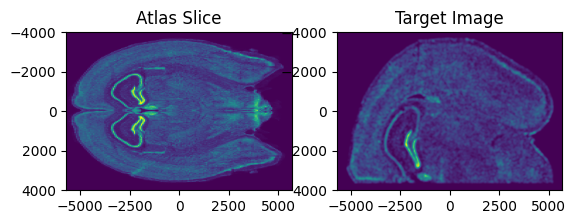

In [433]:
from scipy.ndimage import rotate

theta_deg = 90

fig,ax = plt.subplots(1,2)
extentA = STalign.extent_from_x(xA[1:])
ax[0].imshow(rotate(A[slice], angle=theta_deg),extent=extentA)
ax[0].set_title('Atlas Slice')

ax[1].imshow(W,extent=extentA)
ax[1].set_title('Target Image')
fig.canvas.draw()

In [434]:
points_atlas = np.array([[3000,-300]])
points_target = np.array([[0,-250]])
Li,Ti = STalign.L_T_from_points(points_atlas,points_target)

In [435]:
xJ = [Y_,X_]
J = W[None]/np.mean(np.abs(W))
xI = xA
I = A[None] / np.mean(np.abs(A),keepdims=True)
I = np.concatenate((I,(I-np.mean(I))**2))

In [436]:
sigmaA = 2 #standard deviation of artifact intensities
sigmaB = 2 #standard deviation of background intensities
sigmaM = 2 #standard deviation of matching tissue intenities
muA = torch.tensor([3,3,3],device='cpu') #average of artifact intensities
muB = torch.tensor([0,0,0],device='cpu') #average of background intensities

Text(0.5, 1.0, 'Intensity Histogram of Target Image')

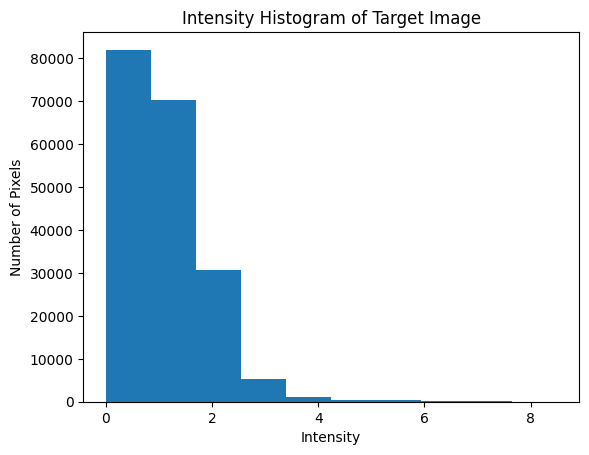

In [437]:
fig,ax = plt.subplots()
ax.hist(J.ravel())
plt.xlabel('Intensity')
plt.ylabel('Number of Pixels')
plt.title('Intensity Histogram of Target Image')

In [438]:
# initialize variables
scale_x = 0.9 #default = 0.9
scale_y = 0.9 #default = 0.9
scale_z = 0.9 #default = 0.9
theta0 = (np.pi/180)*theta_deg

# get an initial guess
if 'Ti' in locals():
    T = np.array([-xI[0][slice],np.mean(xJ[0])-(Ti[0]*scale_y),np.mean(xJ[1])-(Ti[1]*scale_x)])
else:
    T = np.array([-xI[0][slice],np.mean(xJ[0]),np.mean(xJ[1])])

scale_atlas = np.array([[scale_z,0,0],
                        [0,scale_x,0],
                        [0,0,scale_y]])
L = np.array([[1.0,0.0,0.0],
              [0.0,np.cos(theta0),-np.sin(theta0)],
              [0.0,np.sin(theta0),np.cos(theta0)]])
L = np.matmul(L,scale_atlas)#np.identity(3)

/Users/ab70/DataspellProjects/nichecompass_atlas_registration/venv/lib/python3.9/site-packages/STalign/STalign.py:1616: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axE[2].set_yscale('log')


CPU times: user 59min 57s, sys: 19min 27s, total: 1h 19min 24s
Wall time: 1h 18min 38s


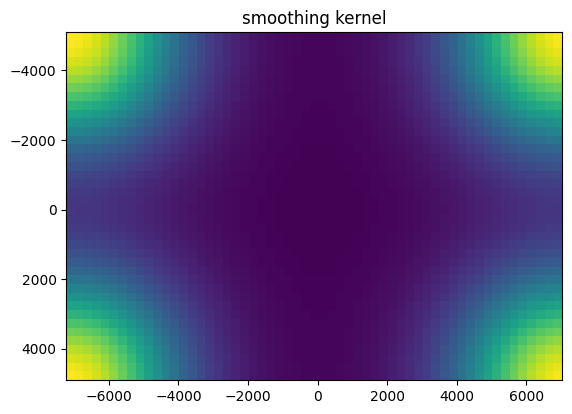

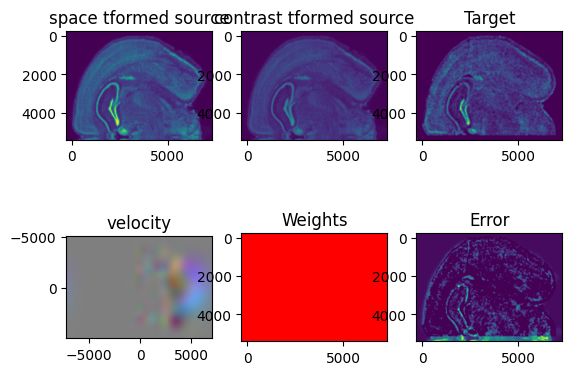

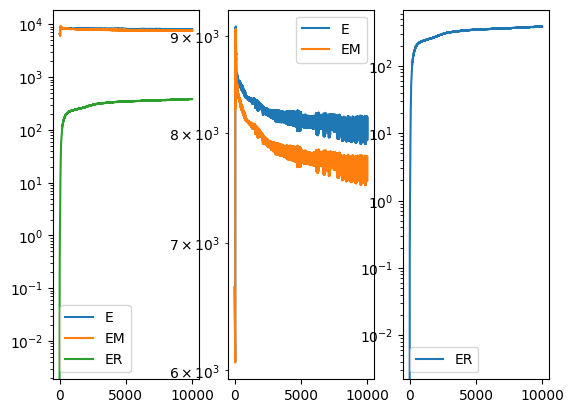

In [451]:
%%time

# run LDDMM
# specify device (default device for STalign.LDDMM is cpu)
if torch.cuda.is_available():
    device = 'cuda:0'
else:
    device = 'cpu'

#returns mat = affine transform, v = velocity, xv = pixel locations of velocity points
transform = STalign.LDDMM_3D_to_slice(
    xI,I,xJ,J,
    T=T,L=L,
    nt=4,niter=10000,
    device='cpu',
    sigmaA = sigmaA, #standard deviation of artifact intensities
    sigmaB = sigmaB, #standard deviation of background intensities
    sigmaM = sigmaM, #standard deviation of matching tissue intenities
    muA = muA, #average of artifact intensities
    muB = muB #average of background intensities
)

In [452]:
A = transform['A']
v = transform['v']
xv = transform['xv']
Xs = transform['Xs']

In [453]:
df = STalign.analyze3Dalign(labelfile,  xv,v,A, xJ, dx, scale_x=scale_x, scale_y=scale_y,x=coordinates["x"],y=coordinates["y"], X_=X_, Y_=Y_, namesdict=namesdict,device='cpu')

/Users/ab70/DataspellProjects/nichecompass_atlas_registration/venv/lib/python3.9/site-packages/STalign/STalign.py:1725: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A = torch.tensor(A)
/Users/ab70/DataspellProjects/nichecompass_atlas_registration/venv/lib/python3.9/site-packages/STalign/STalign.py:1726: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  v = torch.tensor(v)
/Users/ab70/DataspellProjects/nichecompass_atlas_registration/venv/lib/python3.9/site-packages/STalign/STalign.py:1738: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  XJ = t

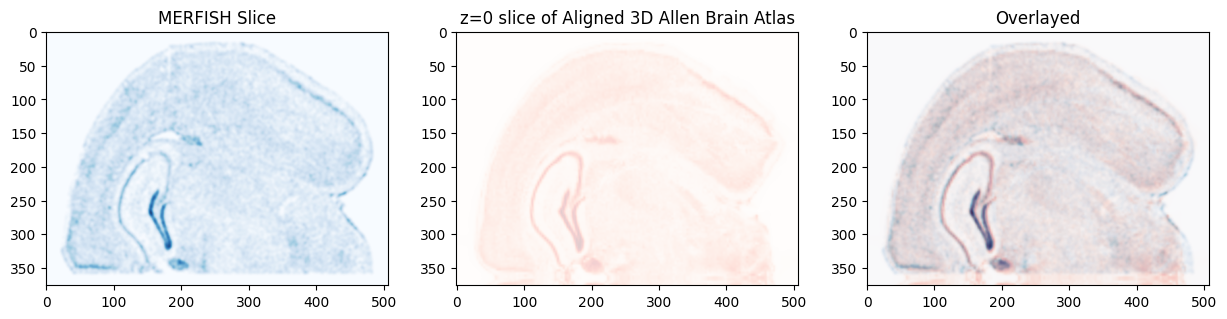

In [454]:
It = torch.tensor(I,device='cpu',dtype=torch.float64)
AI = STalign.interp3D(xI,It,Xs.permute(3,0,1,2),padding_mode="border")
Ishow_source = ((AI-torch.amin(AI,(1,2,3))[...,None,None])/(torch.amax(AI,(1,2,3))-torch.amin(AI,(1,2,3)))[...,None,None,None]).permute(1,2,3,0).clone().detach().cpu()
Jt = torch.tensor(J,device='cpu',dtype=torch.float64)
Ishow_target = Jt.permute(1,2,0).cpu()/torch.max(Jt).item()

import matplotlib as mpl
fig,ax = plt.subplots(1,3, figsize=(15,5))
ax0 = ax[0].imshow(Ishow_target, cmap = mpl.cm.Blues,alpha=0.9)
ax[0].set_title('MERFISH Slice')
ax1 = ax[1].imshow(Ishow_source[0,:,:,0], cmap = mpl.cm.Reds,alpha=0.2)
ax[1].set_title('z=0 slice of Aligned 3D Allen Brain Atlas')
ax2 = ax[2].imshow(Ishow_target, cmap = mpl.cm.Blues,alpha=0.9)
ax2 = ax[2].imshow(Ishow_source[0,:,:,0], cmap = mpl.cm.Reds,alpha=0.3)
ax[2].set_title('Overlayed')

plt.show()


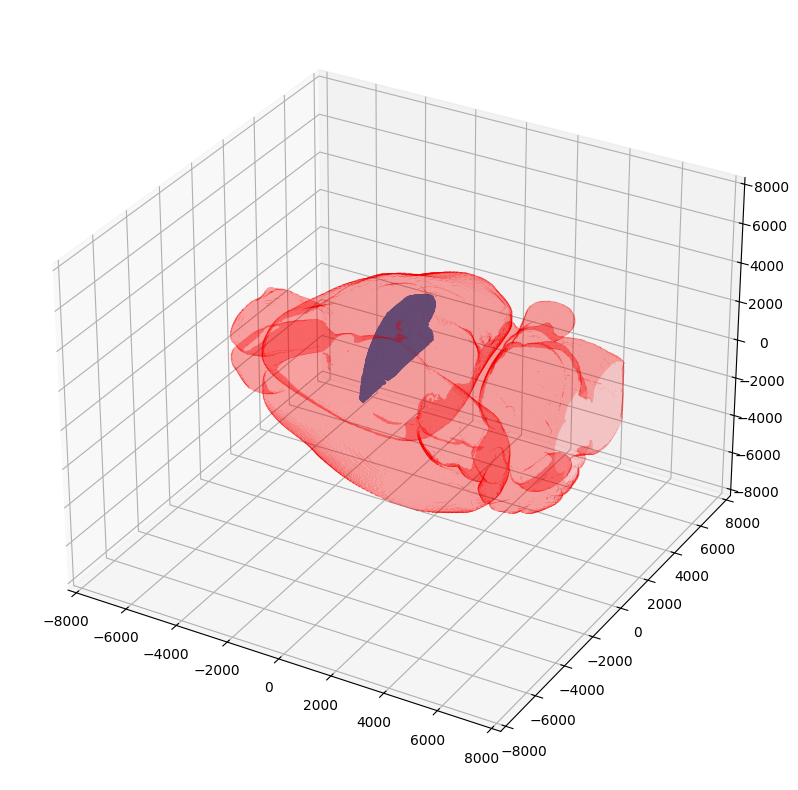

In [455]:
verts, faces, normals, values = skimage.measure.marching_cubes(vol>0,0.8,spacing = dxA)
verts = verts + np.array([x[0] for x in xA])
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
mesh = Poly3DCollection(verts[faces])
#mesh.set_edgecolor('k')
mesh.set_facecolor('r')
mesh.set_alpha(0.2)
ax.add_collection3d(mesh)
ax.set_xlim(-8000, 8000)  # a = 6 (times two for 2nd ellipsoid)
ax.set_ylim(-8000, 8000)  # b = 10
ax.set_zlim(-8000, 8000)  # c = 16
x = df['coord0']
y = df['coord1']
z = df['coord2']
#ax.grid(True)
#ax.set_xticks([])
#ax.set_yticks([])
#ax.set_zticks([])
#pos1 = ax.get_position()
#pos = [pos1.x0 +0.3, pos1.y0+0.3, pos1.width/2, pos1.height/2]
#ax.set_position(pos)
ax.scatter3D(x,y,z, s= 0.1)

#ax.view_init(-240, 90)
#ax.view_init(-90, 120)

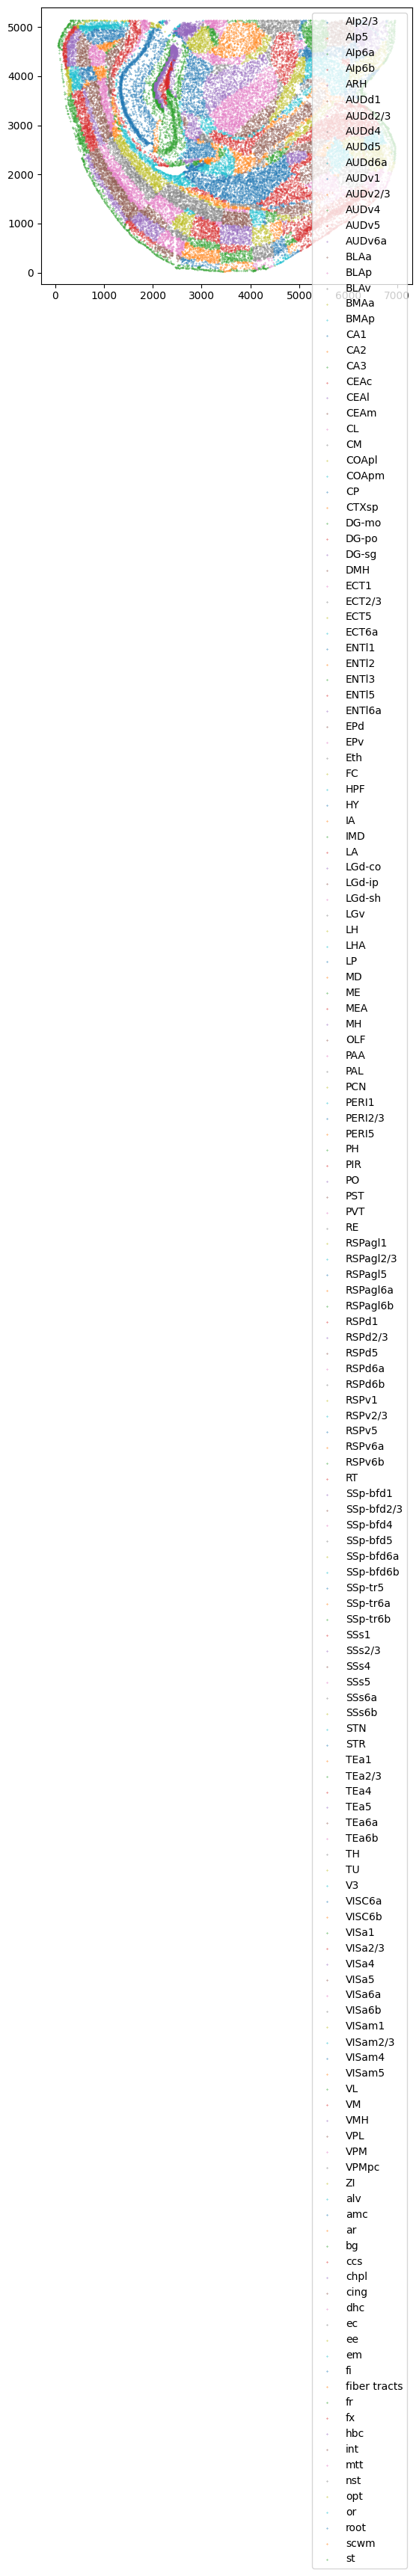

In [456]:
STalign.plot_brain_regions(df)

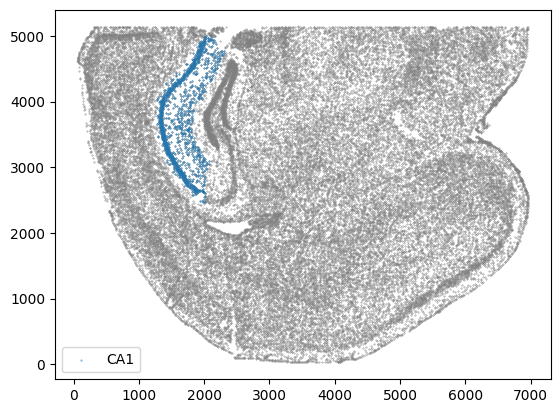

In [457]:
brain_regions = ['CA1']
STalign.plot_subset_brain_regions(df, brain_regions)

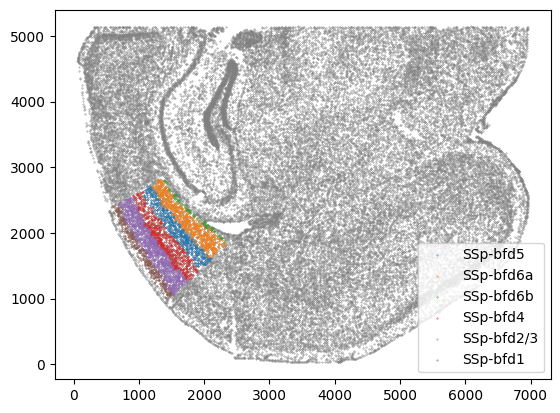

In [458]:
brain_regions = ['SSp-bfd5', 'SSp-bfd6a', 'SSp-bfd6b', 'SSp-bfd4', 'SSp-bfd2/3', 'SSp-bfd1']
STalign.plot_subset_brain_regions(df, brain_regions)

In [459]:
df.to_csv("spatial_8327576_well11_aligned_to_atlas.csv")